Epoch: 1000/1000

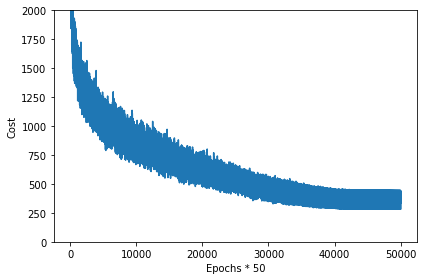

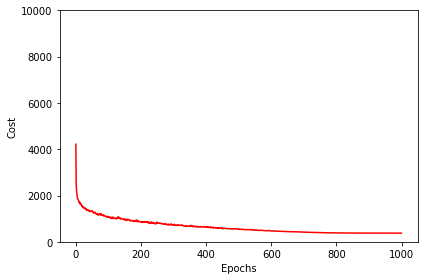

训练准确率: 97.59%
测试准确率: 95.86%


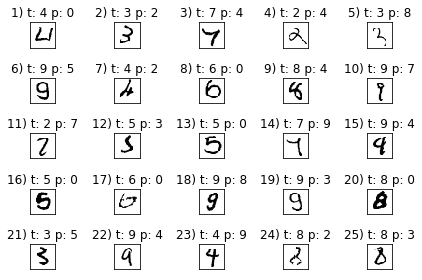

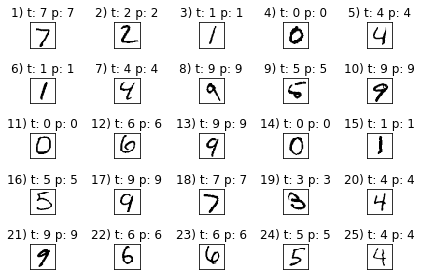

In [11]:
import os
import numpy as np
import struct
import matplotlib.pyplot as plt
import sys
from scipy.special import expit


def load_mnist(kind = 'train'):
    '''
    读取数据
    :param kind: 文件类型
    :return: images: 60000*784
            labels:手写数字对应的类标（整数0~9）
    '''
    labels_path = os.path.join('%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join('%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype= np.uint8).reshape(len(labels), 784) # 28*28=784

    return images, labels


def testPlt09(X_train, y_train):# 按照2*5的方式排列显示单个数字的图像
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, ) # 两行五列

    ax = ax.flatten() # 折叠成一维数组
    for i in range(10):
        img = X_train[y_train == i][0].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

    
def testPlt7(X_train, y_train): # 绘制数字7的前25个不同变体
    fig, ax = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True,)
    ax = ax.flatten()
    for i in range(25):
        img = X_train[y_train == 7][i].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

    
class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30, l1=0.0,
                 l2=0.0, epochs=500, eta=0.001, alpha=0.0, decrease_const=0.0,
                 shuffle=True, minibatches=1, random_state=None):
        '''
        :param n_output: 输出单元
        :param n_features: 输入单元
        :param n_hidden: 隐层单元
        :param l1: L1正则化系数 lamda
        :param l2: L2正则化系数 lamda
        :param epochs: 遍历训练集的次数（迭代次数）
        :param eta: 学习速率
        :param alpha: 动量学习进度的参数，它在上一轮的基础上增加一个因子，用于加快权重更新的学习
        :param decrease_const: 用于降低自适应学习速率 n 的常数 d ，随着迭代次数的增加而随之递减以更好地确保收敛
        :param shuffle: 在每次迭代前打乱训练集的顺序，以防止算法陷入死循环
        :param minibatches: 在每次迭代中，将训练数据划分为 k 个小的批次，为加速学习的过程，
                            梯度由每个批次分别计算，而不是在整个训练集数据上进行计算。
        :param random_state:
        '''
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

        
    def _encode_labels(self, y, k):
        '''
        :param y:
        :param k:
        :return:
        '''
        onehot = np.zeros((k, y.shape[0]))
        for idx, val, in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    
    def _initialize_weights(self):
        '''
        计算权重
        :return: w1, w2
        '''
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    
    def _sigmoid(self, z):
        '''
        expit 等价于 1.0/(1.0 + np.exp(-z))
        :param z:
        :return: 1.0/(1.0 + np.exp(-z))
        '''
        return expit(z)

    
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)

    
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how =='row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:,:] = X
        else:
            raise AttributeError("'how' must be 'column' or 'row'")
        return X_new

    
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:,1:]).sum() + np.abs(w2[:, 1:]).sum())

    
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w2, w1):
        # 反向传播
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
        # 调整
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2

    
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    
    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):
            # 自适应学习率
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_data = X_data[idx], y_data[idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                # 前馈
                a1, z2, a2, z3, a3 = self._feedforward(X[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                self.cost_.append(cost)

                # 通过反向传播计算梯度
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx],
                                                  w1=self.w1, w2=self.w2)

                # 更新权重
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

    
def costplt1(nn):
    plt.plot(range(len(nn.cost_)), nn.cost_)
    plt.ylim([0, 2000])
    plt.ylabel('Cost')
    plt.xlabel('Epochs * 50')
    plt.tight_layout()
    plt.show()

    
def costplt2(nn):
    '''代价函数图象'''
    batches = np.array_split(range(len(nn.cost_)), 1000)
    cost_ary = np.array(nn.cost_)
    cost_avgs = [np.mean(cost_ary[i]) for i in batches]

    plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
    plt.ylim([0, 10000])
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

    
if __name__ == '__main__':
    # images, labels = load_mnist(path)
    # print(np.shape(images), labels)
    # 训练样本和测试样本
    X_train, y_train = load_mnist(kind='train') # X_train : 60000*784
    # print(np.shape(X_train),y_train)
    X_test, y_test = load_mnist(kind='t10k') # X_test : 10000*784
    # print(np.shape(X_test), y_test)
    # testPlt09(X_train, y_train)
    # testPlt7(X_train, y_train)

    nn = NeuralNetMLP(n_output=10,
                      n_features=X_train.shape[1],
                      n_hidden=50,
                      l2=0.1,
                      l1=0.0,
                      epochs=1000,
                      eta=0.001,
                      alpha=0.001,
                      decrease_const=0.00001,
                      shuffle=True,
                      minibatches=50,
                      random_state=1)
    nn.fit(X_train, y_train, print_progress=True)
    costplt1(nn)
    costplt2(nn)
    y_train_pred = nn.predict(X_train)
    acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
    print('训练准确率: %.2f%%' % (acc * 100))

    y_test_pred = nn.predict(X_test)
    acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
    print('测试准确率: %.2f%%' % (acc * 100))

    # 错误样本
    miscl_img = X_test[y_test != y_test_pred][:25]
    correct_lab = y_test[y_test != y_test_pred][:25]
    miscl_lab = y_test_pred[y_test != y_test_pred][:25]
    fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
    ax = ax.flatten()
    for i in range(25):
        img = miscl_img[i].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')
        ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

    # 正确样本
    unmiscl_img = X_test[y_test == y_test_pred][:25]
    uncorrect_lab = y_test[y_test == y_test_pred][:25]
    unmiscl_lab = y_test_pred[y_test == y_test_pred][:25]
    fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, )
    ax = ax.flatten()
    for i in range(25):
        img = unmiscl_img[i].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')
        ax[i].set_title('%d) t: %d p: %d' % (i + 1, uncorrect_lab[i], unmiscl_lab[i]))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()